# Imports

In [192]:
import numpy as np
import itertools
from typing import List, Dict
import time
import ast
import pandas
import matplotlib.pylab as plt
import random

In [109]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [114]:
def score_function(seq1, seq2, gap, match, mismatch):
    score = 0
    for x, y in zip(seq1, seq2):
        if x == y:
            score += match
        elif x == '-' or y == '-':
            score += gap
        else:
            score += mismatch
    return score

# First Algo

In [217]:
def update(grid, i, j, ismatch, gap, match, mismatch):
    left = grid[i, j - 1] + gap
    up = grid[i - 1, j] + gap
    dig = grid[i - 1, j - 1] + match if ismatch else grid[i - 1, j - 1] + mismatch
    grid[i, j] = max(left, up, dig)

In [218]:
def init(grid, i, j, gap):
    if i == 0 and j == 0:
        grid[i, j] = 0
    elif i == 0:
        grid[i, j] = grid[i, j-1] + gap
    elif j == 0:
        grid[i, j] = grid[i-1, j] + gap
    else:
        raise("error")

In [268]:
def nw(x, y, debug, gap=-2, match=1, mismatch=-1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [269]:
def algorithm1(seq1, seq2, debug, gap=-2, match=1, mismatch=-1):
    if len(seq1) < len(seq2):
        temp = seq1
        seq1 = seq2
        seq2 = temp
    grid = np.zeros(
        (len(seq1)+1, len(seq2)+1)
    )
    if debug:
        print(grid)
        print(grid.shape)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if i == 0 or j == 0:
                init(grid, i, j, gap)
            else:
                ismatch = seq1[i-1] == seq2[j-1]
                update(grid, i, j, ismatch, gap, match, mismatch)
    if debug:
        print(grid)
        print(i, j)
    result1 = ""
    result2 = ""
    while i > 0 and j > 0:
        ismatch = seq1[i-1] == seq2[j-1]
        if ismatch:
            i -= 1
            j -= 1
            result1 += seq1[i]
            result2 += seq2[j]
            if debug:
                print(result1[::-1])
                print(result2[::-1])
        else:
            left = grid[i, j - 1]
            up = grid[i - 1, j]
            dig = grid[i - 1, j - 1]
            values = [left, up, dig]
            max_value = max(values)
            for idx, value in enumerate(values):
                if value == max_value:
                    if idx == 0:
                        j -= 1
                        result1 += "-"
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    elif idx ==1:
                        i -= 1
                        result1 += seq1[i]
                        result2 += "-"
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    else:
                        i -= 1
                        j -= 1
                        result1 += seq1[i]
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
    if i == 1:
        i -= 1
        result1 += seq1[i]
        result2 += "-"
    elif j == 1:
        j -= 1
        result1 += "-"
        result2 += seq2[j]
    if debug:
        print(i, j, grid[i,j])
        print(result1[::-1])
        print(result2[::-1])
    return result1[::-1], result2[::-1]           

In [270]:
seq1 = "Mohammed"
seq2 = "hamed"

In [271]:
seq2 = "ATGCT"
seq1 = "AGCT"

In [272]:
seq1 = "DISTANCE"
seq2 = "EDIT"

In [273]:
algorithm1(seq2, seq1, debug=False)

('-DISTANCE', 'EDI-T----')

# Analysis

In [423]:
def analysis(algo, sequences: List[str], hyperparameters_list: List[Dict[str, int]], debug: bool):
    """
    Args:
        algorithm: function that accept two string sequences, a debug boolean, and hyperparameters dict
        sequences: list of strings, each string is a sequence that is going to be aligned against every other sequence
        hyperparameters_list: list of hyperparameters dicts
        debug: bool that decided wether or not to print debugging logs
    Returns:
        Dataframe of all the experiment results, and plots standrized theortical time complexity and real runtime.
    """
    data = list(itertools.combinations(sequences, r=2))
    results = []

    for data_point in data:
        seq1, seq2 = data_point
        n = len(seq1)
        m = len(seq2)
        outputs, runtimes, edit_distances, scores  = [], [], [], []
        for i, hyperparameters in enumerate(hyperparameters_list):
            total_times = []
            for _ in range(15):
                start_time = time.time()
                output = algo(seq1, seq2, debug=debug, **hyperparameters)
                total_time = time.time() - start_time
                total_times.append(total_time)
            outputs.append(output)
            runtimes.append(np.mean(total_times))
            edit_distances.append(levenshteinDistance(*output))
            scores.append(score_function(*output, **hyperparameters))
        r = {
            "outputs":outputs, "runtime":np.mean(runtimes),
            "edit distance": edit_distances,
            "score": scores,
            "input size": n*m,
            "input_size": f"{n}, {m}",
            "O(nm)": n*m,
#             "parameter": hyperparameters_list
        }
        results.append(r)
    df = pandas.DataFrame(data=results, index=data)
    df_x = df[['runtime', 'O(nm)']]

    #standardize the values for each predictor variable
    df[['runtime', 'O(nm)']] = ((df_x-df_x.mean())/df_x.std()) + 2
#     df[['runtime', 'O(nm)']] = (df_x - df_x.min()) / (df_x.max() - df_x.min())
    x = df['input size']
    y1 = df['runtime']
    y2 = df['O(nm)']
    plt.plot(x, y1, '.b')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y1, 1))(np.unique(x)), '-b')
    
    plt.plot(x, y2, '.r')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '-r')
    
    plt.xlabel('input size', fontsize=18)
    plt.legend(['runtime', 'runtime', 'O(nm)', 'O(nm)'], loc='upper left')
    return df

### Fake Data for testing

In [424]:
fake_data = [''.join(random.choice(['A', 'G', 'C', 'T']) for _ in range(random.randint(4, 10))) for _ in range(20)]

In [425]:
fake_data[:4]

['AATCATT', 'GAGTTTATC', 'AGCGGAT', 'TATC']

### Experiment using the first algorithm

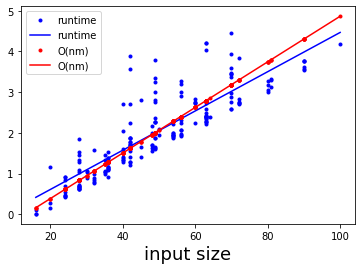

In [426]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results = analysis(
    algo=algorithm1,
    sequences=fake_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [421]:
results[:10]

,outputs,runtime,edit distance,score,input size,input_size,O(nm)
"(GACCTCCTT, GGTTCATGT)","[(GACCTCCT-T, GGT-TCATGT), (GACCTCCT-T, G-GTTC...",4.002818,"[5, 5, 5]","[-2, -3, 0]",81,"9, 9",3.199089
"(GACCTCCTT, ACCGA)","[(GACCTCCTT, -ACCGA---), (GACCTCCTT, -A---CCGA...",2.432916,"[6, 6, 6]","[-7, -5, -3]",45,"9, 5",1.755370
"(GACCTCCTT, TGCG)","[(TCCTT, TGCG-), (TCCTT, TGC-G), (TCCTT, TGCG-)]",2.106605,"[3, 3, 3]","[-2, -3, -1]",36,"9, 4",1.394440
"(GACCTCCTT, TGGACTTAT)","[(GACCTCCTT, GACTTA--T), (GACCTCCT-T, GA-CT--T...",4.376346,"[4, 4, 4]","[-1, 2, 2]",81,"9, 9",3.199089
"(GACCTCCTT, CACGT)","[(GACCTCCTT, CACG----T), (CTCCTT, C-ACGT), (CC...",2.191182,"[6, 3, 4]","[-7, -2, -1]",45,"9, 5",1.755370
"(GACCTCCTT, TCCTTTTGG)","[(GACCTCCTT--, T-CCTT-TTGG), (GACCTCCTT--, -TC...",4.270606,"[6, 6, 6]","[-5, -3, -1]",81,"9, 9",3.199089
"(GACCTCCTT, ACAATTAAGT)","[(-ACAATTAAGT, GACC-TCCT-T), (-ACAAT--TAAGT, G...",5.619936,"[7, 8, 7]","[-6, -4, -3]",90,"9, 10",3.600123
"(GACCTCCTT, CCCG)","[(CCTCCTT, CC-CG--), (CTCCTT, C-CC-G), (CTCCTT...",1.972826,"[4, 3, 3]","[-4, -1, 0]",36,"9, 4",1.394440
"(GACCTCCTT, TATAGTT)","[(GACCTCCTT, TA--TAGTT), (GACCTCCTT, TA--TAGTT...",3.096694,"[5, 5, 5]","[-3, -4, -1]",63,"9, 7",2.477230
"(GACCTCCTT, ACAAGAATAG)","[(-ACAAGAATAG, GACCTCCTT--), (AG-A-AT--AG, G-A...",4.506000,"[8, 7, 8]","[-8, -13, -5]",90,"9, 10",3.600123


### Read Real Data (TODO)

In [ ]:
real_data = # TODO

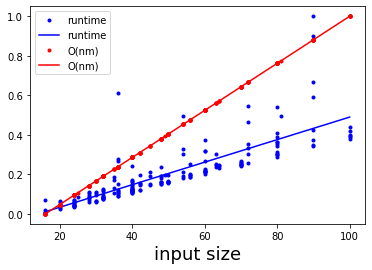

In [360]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results = analysis(
    algo=algorithm1,
    sequences=real_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [361]:
results[:10]

,outputs,runtime,edit distance,score,input size,input_size,O(nm)
"(CCGGCAGCA, TGGGGCACTG)","[(C---------CGGCAGCA, TGGGGCACTG--------), (C-...",0.897637,"[17, 9, 17]","[-35, -19, -18]",90,"9, 10",0.880952
"(CCGGCAGCA, AGGG)","[(C---CGGCAGCA, AGGG--------), (CCGGCAGCA, A--...",0.610901,"[12, 9, 12]","[-23, -13, -12]",36,"9, 4",0.238095
"(CCGGCAGCA, GAGCGCCCCT)","[(C---------CGGCAGCA, GAGCGCCCCT--------), (C-...",0.666493,"[17, 9, 17]","[-35, -19, -18]",90,"9, 10",0.880952
"(CCGGCAGCA, CTCCATTACC)","[(C---------CGGCAGCA, CTCCATTACC--------), (C-...",1.000000,"[17, 9, 17]","[-33, -16, -16]",90,"9, 10",0.880952
"(CCGGCAGCA, CCTACG)","[(C-----CGGCAGCA, CCTACG--------), (CCGGCAGCA,...",0.497150,"[13, 7, 13]","[-25, -12, -12]",54,"9, 6",0.452381
"(CCGGCAGCA, GATTTAACT)","[(C--------CGGCAGCA, GATTTAACT--------), (C--C...",0.496049,"[16, 10, 16]","[-33, -18, -17]",81,"9, 9",0.773810
"(CCGGCAGCA, TCGTTTTG)","[(C-------CGGCAGCA, TCGTTTTG--------), (C-CGGC...",0.465170,"[15, 9, 15]","[-31, -17, -16]",72,"9, 8",0.666667
"(CCGGCAGCA, CGAGCG)","[(C-----CGGCAGCA, CGAGCG--------), (CCGGCAGCA,...",0.326722,"[13, 5, 13]","[-25, -12, -12]",54,"9, 6",0.452381
"(CCGGCAGCA, AATGTTCT)","[(C-------CGGCAGCA, AATGTTCT--------), (C--CGG...",0.545577,"[15, 10, 15]","[-31, -17, -16]",72,"9, 8",0.666667
"(CCGGCAGCA, CCCT)","[(C---CGGCAGCA, CCCT--------), (CCGGCAGCA, C--...",0.266681,"[11, 8, 11]","[-21, -10, -10]",36,"9, 4",0.238095


### Experiment using the second algoritm (TODO)

In [362]:
# TODO

In [ ]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results = analysis(
    algo=algorithm2,
    sequences=real_data,
    hyperparameters_list=hyperparameters_list, debug=False
)